In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') #Quita los largos mensajes de error

plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 120 #Aqui se figa la resolucion del grafico
warnings.simplefilter(action='ignore', category=FutureWarning)

## Calculating Bollinger Bands and testing a buy/sell strategy

1. Import the libraries:

In [3]:
import pandas as pd 
import yfinance as yf
import backtrader as bt
import datetime
import matplotlib.pyplot as plt

2. The template of the strategy looks like:

In [4]:
class BBand_Strategy(bt.Strategy):
    params = (('period', 20),
              ('devfactor', 1.0),)

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close
        self.data_open = self.datas[0].open

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # Añadimos los indicadores de las Bandas de Bollinger y de las señales de compraventa 
        self.b_band = bt.ind.BollingerBands(self.datas[0], 
                                            period=self.p.period, 
                                            devfactor=self.p.devfactor)
        self.buy_signal = bt.ind.CrossOver(self.datas[0], 
                                           self.b_band.lines.bot)
        self.sell_signal = bt.ind.CrossOver(self.datas[0], 
                                            self.b_band.lines.top)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(
                    f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

        # Aqui fijamos la estrategia con de los cruces fijada con los indicadores
    def next_open(self):
        if not self.position:
            if self.buy_signal > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.sell_signal < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

3. Download data:

In [5]:
data = bt.feeds.PandasData(dataname=yf.download('MSFT', '2018-01-01', '2018-12-31'))

[*********************100%%**********************]  1 of 1 completed


4. Set up the backtest:

In [6]:
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)

cerebro.addstrategy(BBand_Strategy)
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')

5. Run the backtest:

In [7]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
2018-02-07, BUY CREATED --- Size: 110, Cash: 10000.00, Open: 90.48999786376953, Close: 89.61000061035156
2018-02-07, BUY EXECUTED --- Price: 90.49, Cost: 9953.90, Commission: 9.95
2018-03-01, SELL CREATED --- Size: 110
2018-03-01, SELL EXECUTED --- Price: 93.99, Cost: 9953.90, Commission: 10.34
2018-03-01, OPERATION RESULT --- Gross: 385.00, Net: 364.71
2018-03-27, BUY CREATED --- Size: 109, Cash: 10364.71, Open: 94.94000244140625, Close: 89.47000122070312
2018-03-27, BUY EXECUTED --- Price: 94.94, Cost: 10348.46, Commission: 10.35
2018-04-16, SELL CREATED --- Size: 109
2018-04-16, SELL EXECUTED --- Price: 94.07, Cost: 10348.46, Commission: 10.25
2018-04-16, OPERATION RESULT --- Gross: -94.83, Net: -115.43
2018-07-03, BUY CREATED --- Size: 102, Cash: 10249.27, Open: 100.4800033569336, Close: 99.05000305175781
2018-07-03, Order Failed
2018-08-23, BUY CREATED --- Size: 95, Cash: 10249.27, Open: 107.1500015258789, Close: 107.55999755859375
2018-08-23, BU

6. Plot the results:

<IPython.core.display.Javascript object>


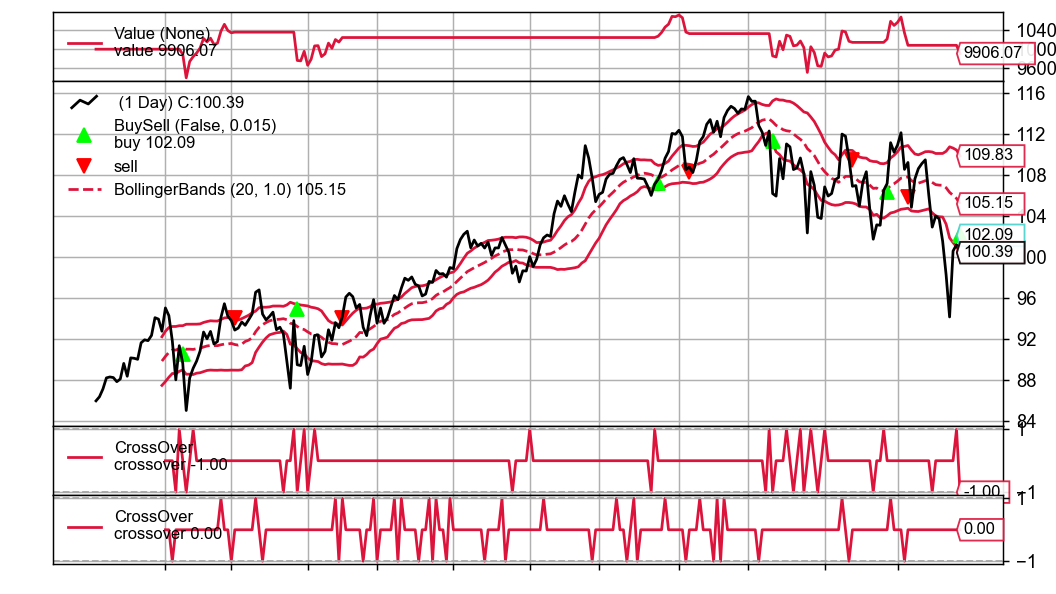

[[<Figure size 960x540 with 4 Axes>]]

In [8]:
cerebro.plot(iplot=True, volume=False)

7. Run to investigate different returns metrics:

In [9]:
print(backtest_result[0].analyzers.returns.get_analysis())

OrderedDict([('rtot', -0.009437574751812778), ('ravg', -3.775029900725111e-05), ('rnorm', -0.009467969194590845), ('rnorm100', -0.9467969194590845)])


8. Create a plot of daily portfolio returns:

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 120
warnings.simplefilter(action='ignore', category=FutureWarning)

<IPython.core.display.Javascript object>


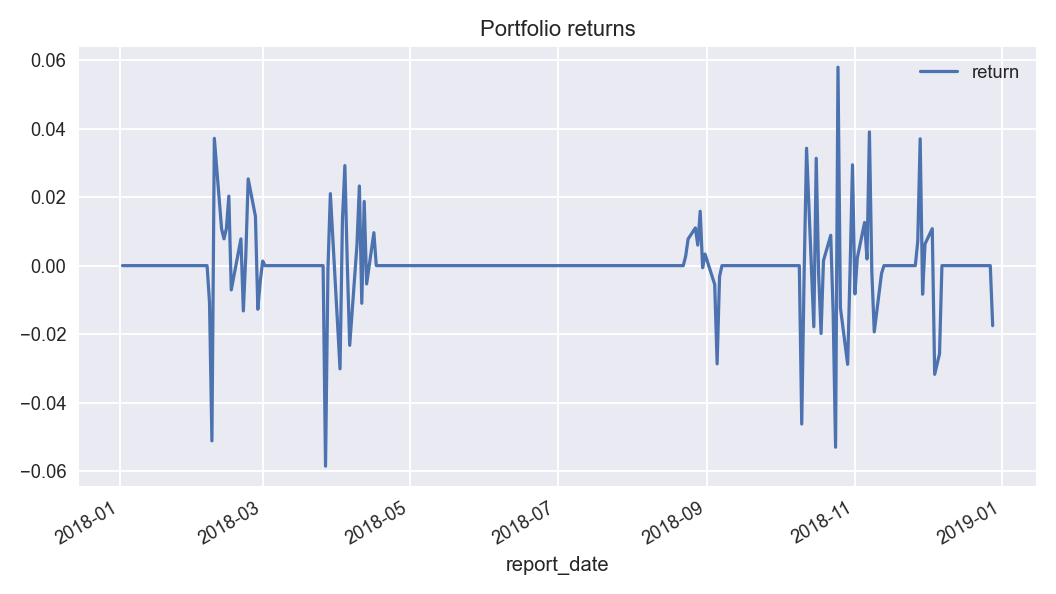

In [13]:
returns_dict = backtest_result[0].analyzers.time_return.get_analysis()
returns_df = pd.DataFrame(list(returns_dict.items()), 
                          columns = ['report_date', 'return']) \
               .set_index('report_date')
returns_df.plot(title='Portfolio returns')

plt.tight_layout()
plt.show()